<a href="https://colab.research.google.com/github/DrAlexSanz/Image-SR/blob/master/Toy_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is just a small toy rehearsal of an autoencoder to develop the SR autoencoder with the bigger dataset. It also does a U-NET or ResAE. Not really a U-Net.


In [0]:
import numpy as np
import os, shutil
from keras import backend as K
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Add, BatchNormalization, Concatenate, Conv2DTranspose
from keras.models import Model, load_model
from keras.utils import plot_model
from keras.optimizers import Adam, Adadelta, Adagrad
from keras.callbacks import History, ModelCheckpoint
import matplotlib.pyplot as plt

K.set_image_data_format("channels_first")

#Data
from keras.datasets import mnist

I want to denoise. Load the dataset, discard the y's and add noise to the x's to obtain the inputs.

In [0]:
(X_train, _), (X_test, _) = mnist.load_data()

In [0]:
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

X_train = X_train/255
X_test = X_test/255


X_val = X_train[0:10000, :, :]
X_train = X_train[10001:, :, :]

This is a matrix (28, 28). I want a tensor of shape (n_pics, 1, 28, 28)

In [4]:
X_train.shape

(49999, 28, 28)

In [0]:
X_train = np.reshape(X_train, (len(X_train), 1, 28, 28)) # First is the whole set, it fits in memory. It's 60k samples of (1, 28, 28) tensors
X_test = np.reshape(X_test, (len(X_test), 1, 28, 28))
X_val = np.reshape(X_test, (len(X_val), 1, 28, 28))

In [6]:
X_train[0].shape

(1, 28, 28)

Make noisy images.

In [0]:
noise_fact = 0.5

X_noisy_train = X_train + noise_fact * np.random.normal(loc = 0, scale = 1, size = X_train.shape)
X_noisy_test = X_test + noise_fact * np.random.normal(loc = 0, scale = 1, size = X_test.shape)
X_noisy_val = X_val + noise_fact * np.random.normal(loc = 0, scale = 1, size = X_val.shape)

X_noisy_train = np.clip(X_noisy_train, 0, 1)
X_noisy_test = np.clip(X_noisy_test, 0, 1)
X_noisy_val = np.clip(X_noisy_val, 0, 1)

Plot to see the pictures.

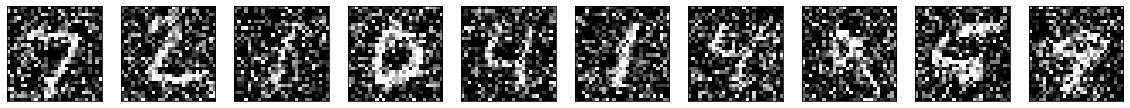

In [10]:
n = 10
plt.figure(figsize = (20,2))

for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(X_noisy_val[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

This should be ok. Now let's define a function to create a small autoencoder.

In [0]:
def small_AE():
    """
    This function returns a keras model instance. Compile and fit is done outside.
    """
    
    input_image = Input(shape = (1, 28, 28))
    
    X = Conv2D(filters = 32, kernel_size = (3, 3), strides = 1, activation = "sigmoid", padding = "same")(input_image)
    
    X = Conv2D(filters = 64, kernel_size = (3, 3), strides = 2, activation = "sigmoid", padding = "same")(X)
    X = BatchNormalization()(X)
        
    encoded = Conv2D(filters = 128, kernel_size = (3, 3), strides = 2, activation = "sigmoid", padding = "same")(X)
    
    
    X = UpSampling2D((2, 2))(encoded)
    
    X = BatchNormalization()(X)
    
    X = Conv2D(filters = 64, kernel_size = (3, 3), strides = 1, activation = "sigmoid", padding = "same")(X)
    
    X = BatchNormalization()(X)
    
    X = UpSampling2D((2, 2))(X)
    
    decoded = Conv2D(filters = 1, kernel_size = (3, 3), strides = 1, activation = "sigmoid", padding = "same")(X)
    
    AE = Model(input_image, decoded)
    
    return AE

In [0]:
# toy_AE = small_AE()

# print(toy_AE.summary())

In [0]:
# plot_model(toy_AE, to_file = "toy_AE.png",show_shapes = True)

As a quick model this works for different trials. I'll improve the architecture later.

In [0]:
# opti = Adadelta(lr = 5e-2)
# hist = History()
# toy_AE.compile(optimizer = opti, loss = "mean_squared_error")

In [0]:
# toy_AE.fit(X_noisy_train, X_train, epochs = 200, batch_size = 128, shuffle = True, validation_data = (X_noisy_test, X_test), callbacks = [hist])

In [0]:
# print(hist.history.keys())

In [0]:
# plt.figure();
# plt.title("Accuracy per epoch")

# plt.plot(range(200), list(hist.history.values())[1]);

Ok, this doesn't work too well at training. Let's add the Unet connections.

In [0]:
def small_UNET():
    """
    This function returns a keras model instance. Compile and fit is done outside.
    """
    
    input_image = Input(shape = (1, 28, 28))
    
    X1 = Conv2D(filters = 64, kernel_size = (3, 3), strides = 1, activation = "tanh", padding = "same")(input_image)
    
    X2 = Conv2D(filters = 64, kernel_size = (3, 3), strides = 2, activation = "tanh", padding = "same")(X1)
    
    X2 = BatchNormalization()(X2)
        
    encoded = Conv2D(filters = 64, kernel_size = (3, 3), strides = 2, activation = "tanh", padding = "same")(X2)
    
    
    X3 = UpSampling2D((2, 2))(encoded)
    
    X4 = Conv2D(filters = 64, kernel_size = (3, 3), strides = 1, activation = "tanh", padding = "same")(X3)
    
#     X4 = Add()([X4, X2])
    # Don't add like in a ResNet! This is a convnet, if I add I am feeding info, as I want, but it's kind of hidden by the addition
    # Concat preserves the info better intuitively. Both will work but conceptually concatenate should work better.

    X4 = Concatenate(axis = 1)([X4, X2])
    
    X4 = BatchNormalization()(X4)
    
    X5 = UpSampling2D((2, 2))(X4)
    
#     X5 = Add()([X5, X1])

    X5 = Concatenate(axis = 1)([X5, X1])
    
    decoded = Conv2D(filters = 1, kernel_size = (3, 3), strides = 1, activation = "sigmoid", padding = "same")(X5)
    
    AE = Model(input_image, decoded)
    
    return AE

In [0]:
toy_Unet = small_UNET()

print(toy_Unet.summary())

In [0]:
plot_model(toy_Unet, to_file = "toy_Unet.png",show_shapes = True)

In [0]:
opti = Adadelta(lr = 5e-2)
hist = History()
path = "epoch{epoch:04d}.h5" #the current one
checkpointer = ModelCheckpoint(path, period = 25, save_weights_only = False)
toy_Unet.compile(optimizer = opti, loss = "mean_squared_error")

In [0]:
toy_Unet = load_model("epoch0175.h5")

In [17]:
toy_Unet.fit(x = X_noisy_train, y = X_train, epochs = 25, batch_size = 128, shuffle = True, validation_data = (X_noisy_test, X_test), callbacks = [hist, checkpointer])

Train on 49999 samples, validate on 10000 samples
Epoch 1/25
49999/49999 [==============================] - 20s 394us/step - loss: 0.0122 - val_loss: 0.0120
Epoch 2/25
49999/49999 [==============================] - 19s 381us/step - loss: 0.0122 - val_loss: 0.0120
Epoch 3/25
49999/49999 [==============================] - 19s 381us/step - loss: 0.0122 - val_loss: 0.0120
Epoch 4/25
49999/49999 [==============================] - 19s 381us/step - loss: 0.0122 - val_loss: 0.0121
Epoch 5/25
49999/49999 [==============================] - 19s 380us/step - loss: 0.0122 - val_loss: 0.0120
Epoch 6/25
49999/49999 [==============================] - 19s 381us/step - loss: 0.0122 - val_loss: 0.0120
Epoch 7/25
49999/49999 [==============================] - 19s 381us/step - loss: 0.0122 - val_loss: 0.0120
Epoch 8/25
49999/49999 [==============================] - 19s 381us/step - loss: 0.0122 - val_loss: 0.0120
Epoch 9/25
49999/49999 [==============================] - 19s 382us/step - loss: 0.0122 - val_

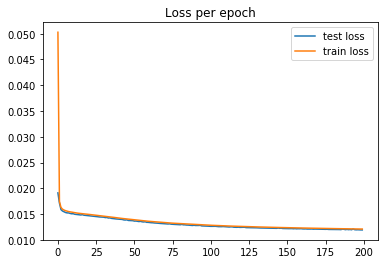

In [21]:
plt.figure();
plt.title("Loss per epoch")

plt.plot(range(200), list(hist.history.values())[0], label = "test loss");
plt.plot(range(200), list(hist.history.values())[1], label = "train loss");
plt.legend()

Let's see the output, I know I don't have a val set, but still.

In [0]:
X_decoded = toy_Unet.predict(X_noisy_val)


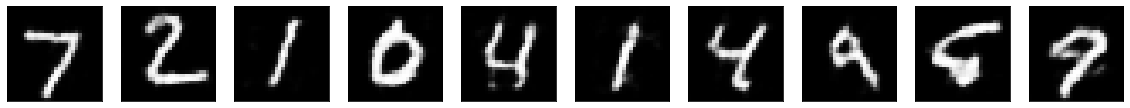

In [23]:
n = 10
plt.figure(figsize = (20,2))

for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(X_decoded[i * 3].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [0]:
def Big_UNET(height, width, n_channels):
    """
    This function returns a keras model instance. Compile and fit is done outside.
    """
    
    input_image = Input(shape = (n_channels, height, width)) # Change later.
    
    X1 = Conv2D(filters = 64, kernel_size = (3, 3), strides = 1, activation = "tanh", padding = "same")(input_image)
    
    X2 = Conv2D(filters = 128, kernel_size = (3, 3), strides = 2, activation = "tanh", padding = "same")(X1)
    
    X2 = BatchNormalization()(X2)
    
    X3 = Conv2D(filters = 256, kernel_size = (4, 3), strides = 2, activation = "tanh", padding = "same")(X2)
    
    X4 = Conv2D(filters = 512, kernel_size = (4, 3), strides = 2, activation = "tanh", padding = "same")(X3)
    
    X4 = BatchNormalization()(X4)
    
    X5 = Conv2D(filters = 1024, kernel_size = (3, 3), strides = 2, activation = "tanh", padding = "same")(X4)
    
    encoded = Conv2D(filters = 2048, kernel_size = (3, 3), strides = 2, activation = "tanh", padding = "same")(X5)
    
    # Decoding part
    
    X5T = Conv2DTranspose(filters = 2048, kernel_size = (3, 3), strides = 3, activation = "tanh", padding = "same")(encoded)
    
    X4T = Conv2DTranspose(filters = 1024, kernel_size = (3, 3), strides = 3, activation = "tanh", padding = "valid")(X5T)
    
#     X4T = Concatenate(axis = 1)([X4T, X4])
    
    Big_model = Model(input_image, X4T)
    
    return Big_model

In [0]:
big_u = Big_UNET(333, 500, 3)

In [0]:
big_u.summary()

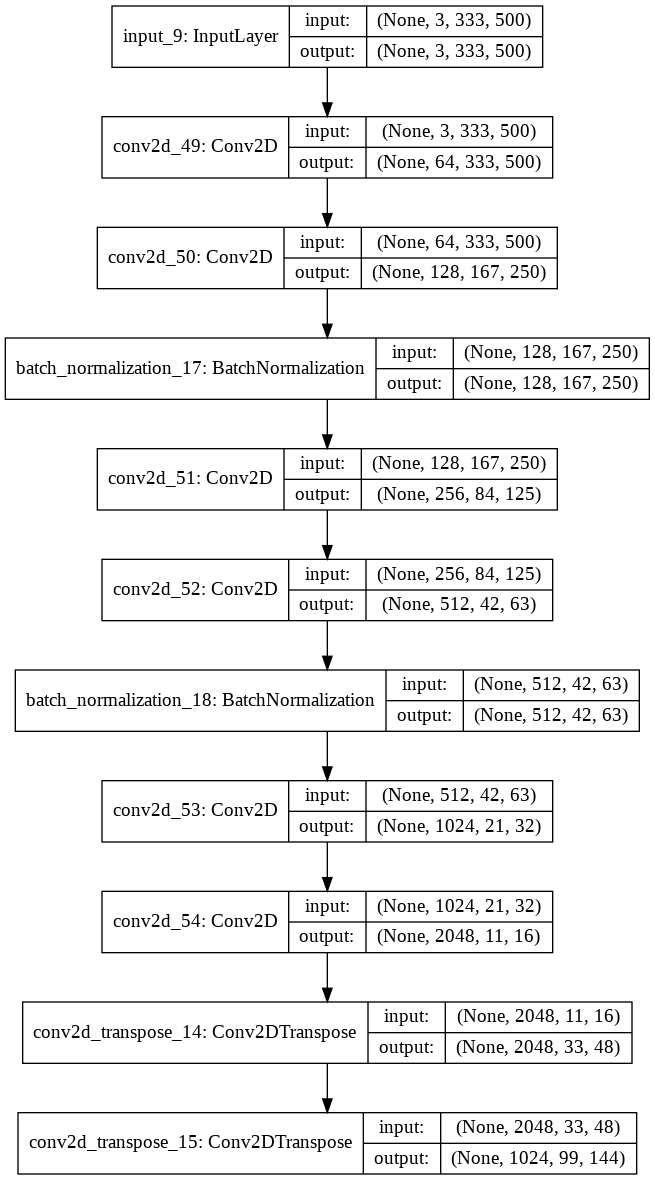

In [45]:
plot_model(big_u, to_file = "Big_Unet.png",show_shapes = True)